# Source detection

In [1]:
import subprocess
# import multiprocess
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.visualization import make_lupton_rgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use("default")
plt.rc('xtick', direction='in', top=True)
plt.rc('ytick', direction='in', right=True)
plt.rc('axes', linewidth=1.15)

plt.rc("mathtext", fontset="dejavuserif")

In [3]:
if not os.path.exists('../Data/Source_cat'):
    os.system('mkdir ../Data/Source_cat')

if not os.path.exists('../Data/Source_cat/BG_maps'):
    os.system('mkdir ../Data/Source_cat/BG_maps')

image_file = "../Data/Images/merged_image_200_2300.fits"
expmap_file = "../Data/Images/merged_expmap_200_2300.fits"

In [4]:
LOG_file = open("../Data/Source_cat/process.log", "w+")

## ERMASK:
It generates a detection mask for the eSASS source detection chain. The resulting product is a FITS image with values 0 and 1, where 1 indicates the image area on which the subsequent source detection tasks will be executed.

In [5]:
def run_ermask(exposure_map, output_mask_file, log_file=None):
    subprocess.run(["ermask", 
                    f"expimage={exposure_map}", 
                    f"detmask={output_mask_file}",
                    ], stdout=log_file, stderr=log_file)

In [6]:
output_mask_file = "../Data/Source_cat/detmask.fits"

if os.path.exists(output_mask_file):
    os.remove(output_mask_file)

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_ermask(expmap_file, output_mask_file, log_file=log_file)

## ERBOX (local):
This step performs sliding box source detection in local mode. The objective of the local detection step is to create an initial list of source positions for the ERBACKMAP task (described below), which then generates a background map from a source-free image.

In [7]:
def run_erbox(image_file, exposure_map, detmask_file, output_boxlist, bkg_map=None, bg_image_flag="N", ecf=1, emin=200, emax=2300, log_file=None):
    if bg_image_flag=="N":
        subprocess.run(["erbox", 
                        f"images={image_file}", 
                        f"expimages={exposure_map}",
                        f"detmasks={detmask_file}",
                        f"boxlist={output_boxlist}",
                        f"emin={emin}",
                        f"emax={emax}",
                        f"bkgima_flag={bg_image_flag}",
                        f"ecf={ecf}",
                        ], stdout=log_file, stderr=log_file)
    else:
        subprocess.run(["erbox", 
                        f"images={image_file}", 
                        f"expimages={exposure_map}",
                        f"detmasks={detmask_file}",
                        f"boxlist={output_boxlist}",
                        f"emin={emin}",
                        f"emax={emax}",
                        f"bkgimages={bkg_map}",
                        f"ecf={ecf}",
                        ], stdout=log_file, stderr=log_file)

In [8]:
output_boxlist_local = "../Data/Source_cat/boxlist_local.fits"

if os.path.exists(output_boxlist_local):
    os.remove(output_boxlist_local)

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_erbox(image_file, expmap_file, output_mask_file, 
              output_boxlist_local, log_file=log_file)

## ERBACKMAP

In [9]:
def run_erbackmap(image_file, exposure_map, detmask_file, boxlist_file, output_bkgmap, output_cheesemask, emin=200, emax=2300, log_file=None):
    subprocess.run(["erbackmap", 
                    f"image={image_file}", 
                    f"expimage={exposure_map}",
                    f"detmask={detmask_file}",
                    f"boxlist={boxlist_file}",
                    f"bkgimage={output_bkgmap}",
                    f"cheesemask={output_cheesemask}",
                    # f"emin={emin}",
                    f"emax={emax}",
                    "cheesemask_flag=Y",
                    "clobber=Y",
                    ], stdout=log_file, stderr=log_file)

In [10]:
output_bkgmap = "../Data/Source_cat/BG_maps/bkg_map.fits"
output_cheesemask = "../Data/Source_cat/BG_maps/cheesemask.fits"

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_erbackmap(image_file, expmap_file, output_mask_file, 
                  output_boxlist_local, output_bkgmap, output_cheesemask, 
                  log_file=log_file)

## ERBOX (map):

In [11]:
output_boxlist_map = "../Data/Source_cat/boxlist_map.fits"

if os.path.exists(output_boxlist_map):
    os.remove(output_boxlist_map)

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_erbox(image_file, expmap_file, output_mask_file, 
              output_boxlist_map, output_bkgmap, log_file=log_file)

## ERMLDET:

In [12]:
def run_ermldet(image_file, exposure_map, detmask_file, boxlist_file,
                bkg_map, output_mllist, output_sourceimage, emin=200, emax=2300, log_file=None):
    subprocess.run(["ermldet", 
                    f"mllist={output_mllist}", 
                    f"boxlist={boxlist_file}",
                    f"images={image_file}",
                    f"expimages={exposure_map}",
                    f"detmasks={detmask_file}",
                    f"bkgimages={bkg_map}",
                    f"srcimages={output_sourceimage}",
                    "extentmodel=gaussian",
                    f"emin={emin}",
                    f"emax={emax}",
                    "srcima_flag=Y"
                    ], stdout=log_file, stderr=log_file)

In [13]:
output_mllist = "../Data/Source_cat/mllist.fits"
output_sourceimage = "../Data/Source_cat/sourceimage.fits"

if os.path.exists(output_mllist):
    os.remove(output_mllist)

if os.path.exists(output_sourceimage):
    os.remove(output_sourceimage)

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_ermldet(image_file, expmap_file, output_mask_file, 
                output_boxlist_map, output_bkgmap, 
                output_mllist, output_sourceimage, log_file=log_file)

## CATPREP:

In [4]:
def run_catprep(input_mllist, out_catfile, log_file=None):
    subprocess.run(["catprep", 
                    f"infile={input_mllist}", 
                    f"outfile={out_catfile}"
                    ], stdout=log_file, stderr=log_file)

output_catalog = "../Data/Source_cat/catalog.fits"

if os.path.exists(output_catalog):
    os.remove(output_catalog)

with open("../Data/Source_cat/process.log", "a") as log_file:
    run_catprep(output_mllist, output_catalog, log_file=log_file)

## Selecting point sources and extended sources:

In [10]:
output_catalog = "../../../eRASS1_Main.v1.1.fits"
with fits.open(output_catalog) as hdul:
    data = hdul[1].data

# Find the number of sources with EXT_LIKE as 0
num_ext_like_0 = np.sum(data['EXT_LIKE'] == 0)

# Find the number of sources with EXT_LIKE not equal to 0
num_ext_like_nonzero = np.sum(data['EXT_LIKE'] != 0)

print(f"Number of sources with EXT_LIKE = 0: {num_ext_like_0}")
print(f"Number of sources with EXT_LIKE != 0: {num_ext_like_nonzero}")

Number of sources with EXT_LIKE = 0: 903521
Number of sources with EXT_LIKE != 0: 26682


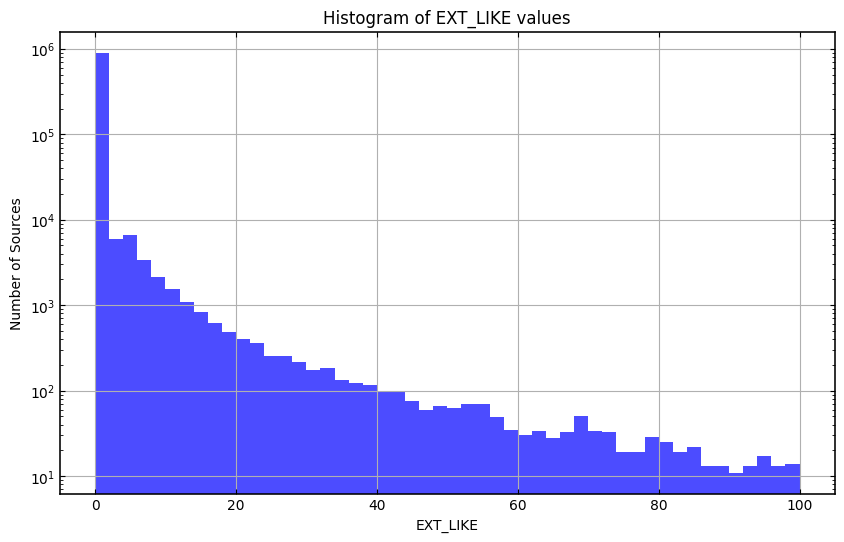

In [14]:
# Extract EXT_LIKE values from the catalog
ext_like_values = data['EXT_LIKE']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ext_like_values[data['EXT_LIKE']<100], bins=50, color='blue', alpha=0.7)
plt.xlabel('EXT_LIKE')
plt.ylabel('Number of Sources')
plt.title('Histogram of EXT_LIKE values')
# plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [26]:
ra_values

array([83.61556178, 83.64403924, 83.62794436, 84.72630143, 80.44065684,
       84.2147348 , 84.20131881, 82.76734565, 82.75011785, 84.87789061,
       83.64556493, 83.66126011, 82.31780755, 83.61313381, 83.61352055,
       81.34441986, 84.150983  , 81.65928691, 80.44402699, 85.25571417,
       80.54224307, 81.77403096, 83.05202317, 86.46088082, 86.47450327,
       84.4111014 , 85.27179598, 82.42646945, 81.00852196, 83.250063  ,
       81.76288601, 81.81758467, 83.34890527, 80.70935564, 86.49369838,
       81.10598496, 87.24866387, 80.14658085, 80.69604706, 82.49448408,
       86.54325062, 84.74079826, 85.87104726, 87.43813468, 82.89432444,
       87.25375136, 82.25156455, 82.49133027, 83.66488872, 83.86294436,
       85.10638654, 87.00209488, 87.46883167, 84.79803075, 80.70791343,
       85.58999726, 86.66546203, 79.96703869, 79.82009002, 82.84180228,
       84.04536135, 86.63627751, 81.24375568, 82.85145726, 81.03354329,
       82.17030389, 80.1543887 , 81.4373184 , 79.37979206, 84.24

In [37]:
max(size_pix), max(data['EXT'])

(16.67899, 66.71596)

In [38]:
# Find the index of the maximum value in data['EXT']
max_ext_index = np.argmax(data['EXT'])

# Get the corresponding RA and DEC values
max_ra = data['RA'][max_ext_index]
max_dec = data['DEC'][max_ext_index]

print(f"RA: {max_ra}, DEC: {max_dec}")

RA: 83.60887221431109, DEC: 22.11781498038925


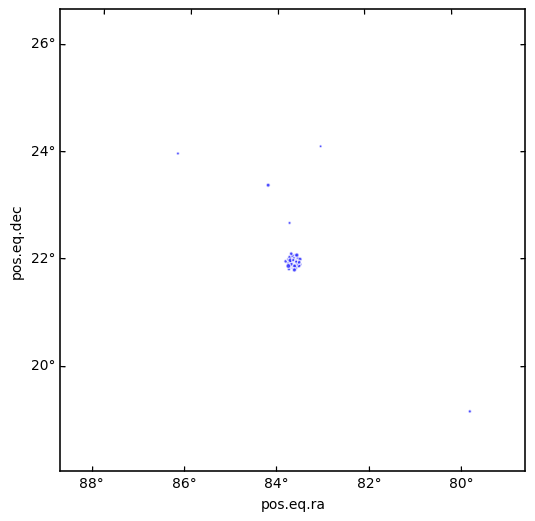

In [33]:
with fits.open(image_file) as hdul:
    w = wcs.WCS(hdul[0].header)

ra_values = data['RA']
dec_values = data['DEC']
ext_values = data['EXT']/3600

pixel_coords = w.wcs_world2pix(np.column_stack((ra_values, dec_values)), 1)

x_coords, y_coords = pixel_coords[:, 0], pixel_coords[:, 1]
size_pix = ext_values/np.abs(w.wcs.cdelt[0])

fig = plt.figure(1, figsize=(6, 6))
ax = plt.subplot(projection=w)
ax.scatter(x_coords, y_coords, s=size_pix, alpha=0.7, edgecolors='w', c='b')
ax.coords[0].set_format_unit('deg')
ax.coords[1].set_format_unit('deg')
plt.show()
